In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [2]:
n_range = range(776, 791)
N = len(n_range)
SXM_PATH = ["electromigration_19/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 9
min_mass = 2
max_mass = 100
min_size = 1
max_ecc = 1
separation = 5
searchRange = 50

In [3]:
%load_ext autoreload
%autoreload 2
f = tp.batch(frames[:], diameter=molecule_size, minmass=min_mass, separation=separation)

Frame 14: 25 features


<Figure size 432x288 with 0 Axes>

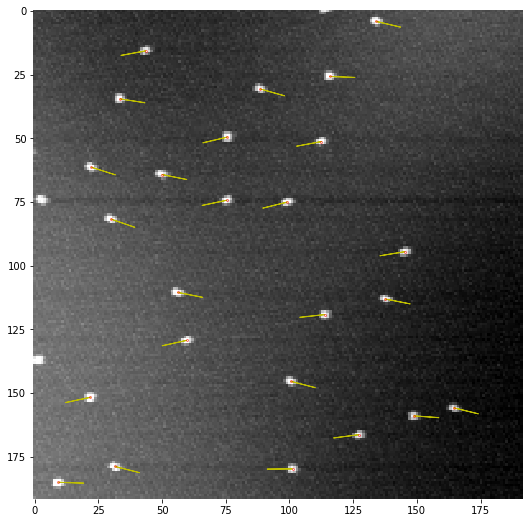

In [4]:
plt.figure()

fig=plt.figure(figsize=(12, 9))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
tp.annotate(f[f['frame']==0], frames[0], plot_style={'markersize': 0.5}, ax=ax1)
R = 10
tmp = f[f.frame == 0]
for i in range(len(tmp)):
    t = tmp.iloc[i]
    plt.arrow(t.x, t.y, R * np.sin(t.orientation), R * np.cos(t.orientation), color='y')

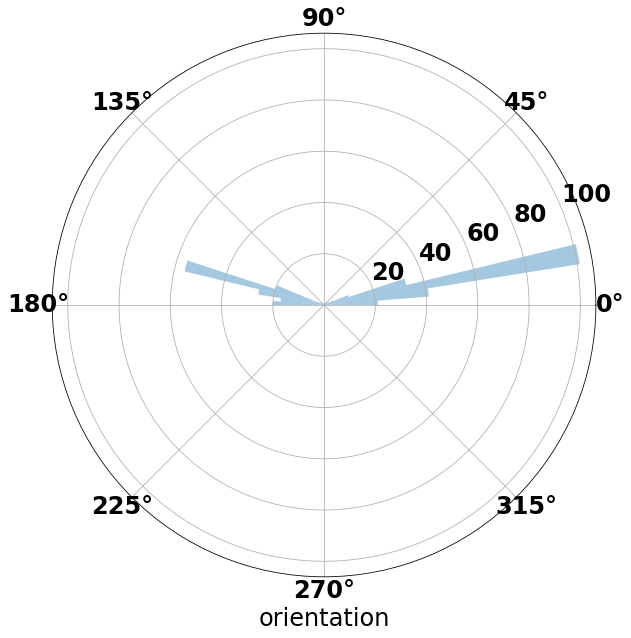

In [17]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
sns.distplot(f.orientation + np.pi/2, kde=False, bins=40)
# plt.axvline(10)

Frame 14: 25 trajectories present.


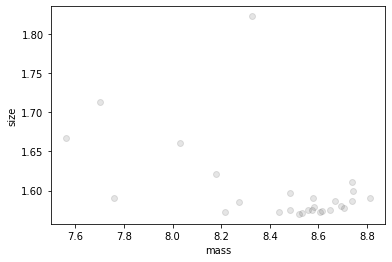

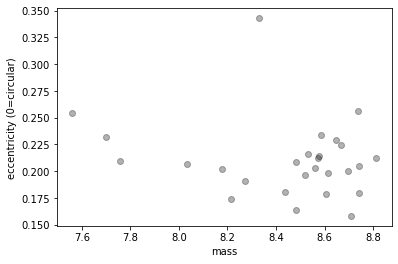

In [6]:
t = tp.link(f, search_range=searchRange, adaptive_stop=10, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [7]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 27
After: 27


In [8]:
t['diff_x'] = t.groupby('particle')['x'].diff().fillna(0)
t['diff_y'] = t.groupby('particle')['y'].diff().fillna(0)
t['alignment'] = pd.cut(t.orientation + np.pi/2, 3, labels=['90', '210', '330'])
t['last_align'] = t.groupby('particle')['alignment'].shift()
t[t.particle == 0].head()

,y,x,mass,size,ecc,orientation,signal,raw_mass,ep,frame,particle,diff_x,diff_y,alignment,last_align
0,4.132235,133.954141,8.232688,1.526262,0.197400,1.341976,0.861390,-5.147633,0.104072,0,0,0.000000,0.000000,330,NaN
25,5.630864,132.784744,8.741875,1.582871,0.132625,-1.345339,0.846977,-2.826096,0.052393,1,0,-1.169397,1.498629,90,330
50,6.172936,132.479032,8.477552,1.615157,0.160155,-1.157483,0.824665,-3.364730,0.046260,2,0,-0.305712,0.542072,90,90


In [9]:
t.groupby('alignment').size()

alignment
90     217
210      5
330    148
dtype: int64

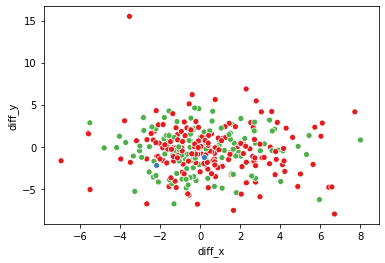

In [10]:
ax = plt.axes()
for p in t.particle.unique():
    tmp = t[t.particle == p]
    sns.scatterplot(data=tmp.iloc[1:], x='diff_x', y='diff_y', hue=tmp.iloc[:-1].alignment, palette=sns.color_palette("Set1", 3), ax=ax)
ax.get_legend().remove()

0.2814919532051806 203
3.6224735390829985 3
0.27438665800593987 137


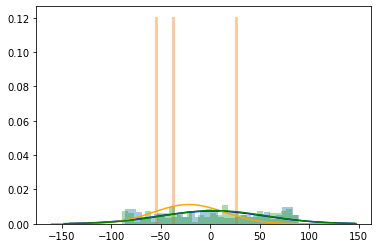

In [11]:
from scipy.stats import norm
ax = plt.axes()
colors = ("blue", "orange", "green")
for i, alignment in enumerate(['90', '210', '330']):
    sns.distplot(np.arctan(t[t.last_align == alignment]['diff_y'] / t[t.last_align == alignment]['diff_x']) * 180 / np.pi, fit=norm, fit_kws={"color":colors[i]}, kde=False, bins=30)
    print(np.mean(t[t.last_align == alignment]['diff_x']), len(t[t.last_align == alignment]))

-0.312983047708664 203
-1.3678455550319129 3
-0.45491842530678034 137


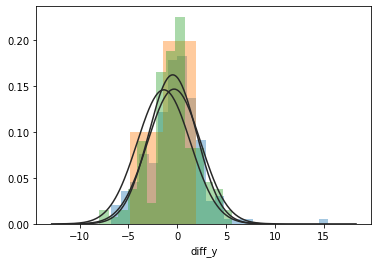

In [12]:
ax = plt.axes()
for alignment in ['90', '210', '330']:
    sns.distplot(t[t.last_align == alignment]['diff_y'], fit=norm, kde=False, norm_hist=False)
    print(np.mean(t[t.last_align == alignment]['diff_y']), len(t[t.last_align == alignment]))

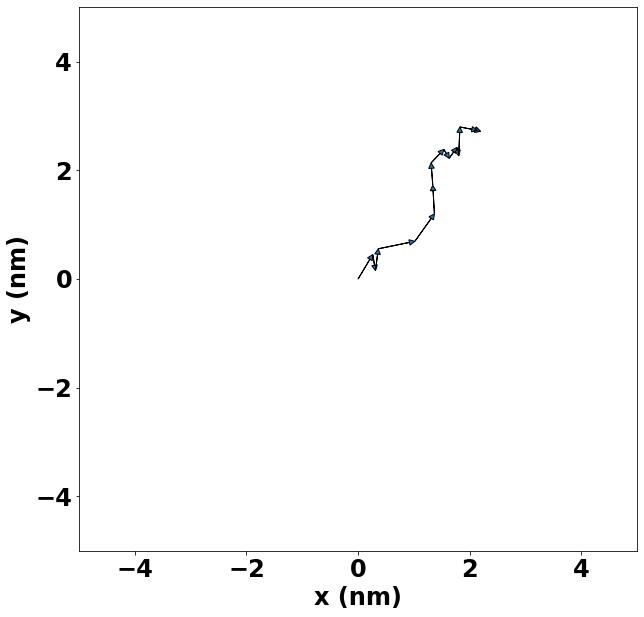

In [13]:
from scipy.stats import norm
NM_PER_PIXEL = frames.meters_per_pixel*1e9
d = tp.compute_drift(t2)

mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(10, 10))
#colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
cmap = plt.cm.get_cmap("magma")

d.loc[0] = [0, 0]
arrs = []
j = 0
d['y'] = d['y']*-1
#     sns.scatterplot(x='x', y='y', data=d * NM_PER_PIXEL, alpha=0.0)
for i in range(1, len(d)):
    d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
    plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
    shape='full', length_includes_head=True, 
    zorder=0, head_length=0.1, head_width=0.1,linewidth=1)
else:
    d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
    arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
    shape='full', length_includes_head=True, 
    zorder=0, head_length=0.1, head_width=0.1,))
#plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()